# Building CNN From Scratch With Keras For Cancer Detection
***By Kris Smith***

## Import Libraries

In [2]:
import numpy as np, pandas as pd
import os
import cv2
from PIL import Image ## For working with images
from glob import glob 
from keras.callbacks import *
from keras.models import *
from keras.layers.normalization import *
from keras.layers.convolutional import *
from keras.layers.core import *
import matplotlib.pyplot as plt
%matplotlib inline
print(os.listdir("../input/histopathologic-cancer-detection"))
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
#############################################################




import os, cv2
from scipy import stats

from tqdm import tqdm_notebook,trange

from time import time

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

from keras.callbacks import TensorBoard

# import the necessary packages
from keras.models import Sequential
# from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K

['sample_submission.csv', 'train_labels.csv', 'test', 'train']
Num GPUs Available:  1


---

# EDA

## Load Data

In [3]:
print(f'Total Number of Samples in Training Data = {len(os.listdir("../input/histopathologic-cancer-detection/train"))}')
print(f'Total Number of Samples in Test Data = {len(os.listdir("../input/histopathologic-cancer-detection/test"))}')

Total Number of Samples in Training Data = 220025
Total Number of Samples in Test Data = 57458


In [4]:
path = "../input/histopathologic-cancer-detection/"
train_path = path + 'train/'
test_path = path + 'test/'

### Read data into pandas frames ###
## Load training and testing file names into frames
df = pd.DataFrame({'path': glob(os.path.join(train_path,'*.tif'))}) 
df_test = pd.DataFrame({'path': glob(os.path.join(test_path,'*.tif'))}) 

## Isolate the id from file names and store as id features in seperate column
df['id'] = df.path.map(lambda x: x.split('/')[4].split(".")[0]) 

## Read in training labels
labels = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')

## Add Labels to training data 
df = df.merge(labels, on = "id") # merge labels and filepaths
df.sample(7)

,path,id,label
37247,../input/histopathologic-cancer-detection/trai...,2b49df16b261ac9f63b7811c2079a0eb9e6f8886,1
27120,../input/histopathologic-cancer-detection/trai...,9df229d68ec8b1920c7eed024a0e38e7af8cfa14,0
21078,../input/histopathologic-cancer-detection/trai...,579a50e1bb9339efd2e2d54f193c47fd9292382f,1
85966,../input/histopathologic-cancer-detection/trai...,1b2ef3592ef143c9bf3d7ca738ed5ca928d5d4ef,0
129987,../input/histopathologic-cancer-detection/trai...,5157ecc2eedcbe44608f3b55b773f647a297d6f2,0
208154,../input/histopathologic-cancer-detection/trai...,7f2640c04e5a7c1f69dd6906e58840a7494e0ac7,1
28346,../input/histopathologic-cancer-detection/trai...,7bbcfafa0dc1a2aaff08e5b5fb1b776e0027681b,0


## Lets Inspect Distribution Among The Classes in Training Data

<AxesSubplot: title={'center': 'Class Distribution in Training Data'}>

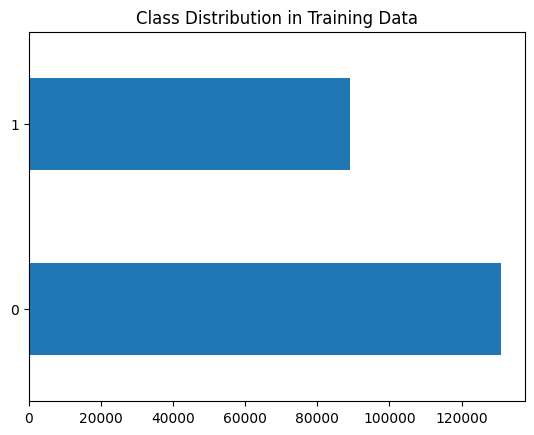

In [5]:
labels['label'].value_counts().plot(kind='barh', title='Class Distribution in Training Data')

## Inspect Some Samples From Both Positive and Negative Classes

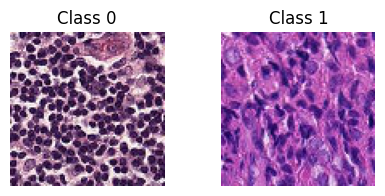

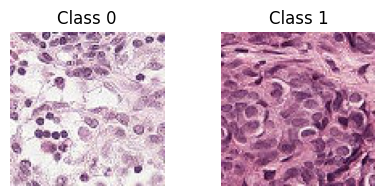

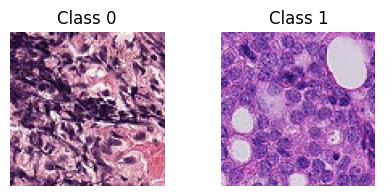

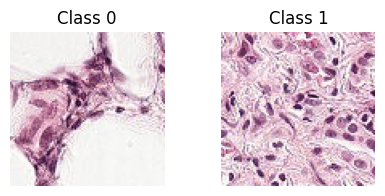

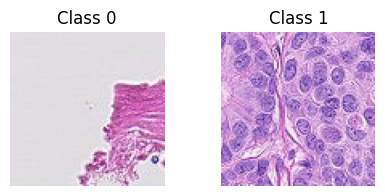

In [6]:
## Filter dataframe to get a subset of each class
class0 = df[df['label'] == 0]
class1 = df[df['label'] == 1]

for image in range(5):
    ## Select a random sample from each class
    sample0 = class0.sample(1)
    sample1 = class1.sample(1)

    ## Open image files and plot
    img_path0 = sample0['path'].values[0]
    img_path1 = sample1['path'].values[0]

    img0 = Image.open(img_path0)
    img1 = Image.open(img_path1)

    fig, ax = plt.subplots(1, 2, figsize=(5, 2))

    ax[0].imshow(img0)
    ax[0].set_title('Class 0')
    ax[0].axis('off')

    ax[1].imshow(img1)
    ax[1].set_title('Class 1')
    ax[1].axis('off')

    plt.show()

*** Inspecting these images I am realizing that I am not a medical professional and therefore I can see no obvious differences between the positive and negative class images. Therefore I will be relying on the labels and the model to distinguish between the two.***

---
# Training

## Split Training Data

In [7]:

# df = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')
# df['label'] = df['label'].astype(str)
# df = df.sample(1000)

In [8]:
# !pip install git+https://github.com/keras-team/keras-preprocessing.git
df = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')

df['label'] = df['label'].astype(str)
# df = df.sample(640)

def append_ext(ID):
    return(ID+".tif")


df["id"] = df["id"].apply(append_ext)



train_datagen = ImageDataGenerator(
       horizontal_flip=True,
       vertical_flip=True,
       #brightness_range=[0.5, 1.5],
       #fill_mode='reflect',                               
        rotation_range=15,
        rescale=1./255,
        #shear_range=0.2,
        #zoom_range=0.2
        validation_split=0.10
    
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_path = '../input/histopathologic-cancer-detection/train'
valid_path = '../input/histopathologic-cancer-detection/train'

train_generator = train_datagen.flow_from_dataframe(
                dataframe=df,
                directory=train_path,
                x_col = 'id',
                y_col = 'label',
#                 has_ext=True,
                subset='training',
                target_size=(96, 96),
                batch_size=64,
                class_mode='binary'
                )

validation_generator = train_datagen.flow_from_dataframe(
                dataframe=df,
                directory=valid_path,
                x_col = 'id',
                y_col = 'label',
#                 has_ext=True,
                subset='validation', # This is the trick to properly separate train and validation dataset
                target_size=(96, 96),
                batch_size=64,
                shuffle=False,
                class_mode='binary'
                )

Found 198023 validated image filenames belonging to 2 classes.
Found 22002 validated image filenames belonging to 2 classes.


## Building Model Architecture

### Model 1

In [9]:
# with tf.device('/gpu:0'):  
#     model = Sequential()
    
#     model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = (96, 96, 3)))
#     model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
#     model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
#     model.add(Dropout(0.3))
#     model.add(MaxPooling2D(pool_size = 3))

#     model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
#     model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
#     model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
#     model.add(Dropout(0.3))
#     model.add(MaxPooling2D(pool_size = 3))

#     model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
#     model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
#     model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
#     model.add(Dropout(0.3))
#     model.add(MaxPooling2D(pool_size = 3))

#     model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'elu'))
#     model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'elu'))
#     model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'elu'))
#     model.add(Dropout(0.3))

#     model.add(Flatten())
#     model.add(Dense(128, activation='relu'))
#     model.add(Dropout(0.3))
#     model.add(Dense(1, activation = 'sigmoid'))
# #     model.summary()

#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#     STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
#     STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

#     history = model.fit(train_generator,
#                         steps_per_epoch=STEP_SIZE_TRAIN,
#                         epochs=15,
#                         validation_data=validation_generator,
#                         validation_steps=STEP_SIZE_VALID)


### Model 2

In [ ]:
with tf.device('/gpu:0'):  
    model = Sequential()
    
    model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = (96, 96, 3)))
    model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(MaxPooling2D(pool_size = 3))

    model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(MaxPooling2D(pool_size = 3))

    model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(MaxPooling2D(pool_size = 3))

    model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'elu'))
    model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'elu'))
    model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'elu'))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation = 'sigmoid'))
#     model.summary()

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
    STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

    history = model.fit(train_generator,
                        steps_per_epoch=STEP_SIZE_TRAIN,
                        epochs=10,
                        validation_data=validation_generator,
                        validation_steps=STEP_SIZE_VALID)


Epoch 1/10


2023-05-22 19:17:12.458609: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


3094/3094 [==============================] - 2054s 660ms/step - loss: 0.4753 - accuracy: 0.7696 - val_loss: 0.5117 - val_accuracy: 0.7533
Epoch 2/10
3094/3094 [==============================] - 942s 305ms/step - loss: 0.3755 - accuracy: 0.8378 - val_loss: 0.4028 - val_accuracy: 0.8318
Epoch 3/10
3094/3094 [==============================] - 795s 257ms/step - loss: 0.3306 - accuracy: 0.8596 - val_loss: 0.3691 - val_accuracy: 0.8388
Epoch 4/10
3094/3094 [==============================] - 784s 253ms/step - loss: 0.2990 - accuracy: 0.8761 - val_loss: 0.3233 - val_accuracy: 0.8650
Epoch 5/10
3094/3094 [==============================] - 769s 248ms/step - loss: 0.2778 - accuracy: 0.8870 - val_loss: 0.2707 - val_accuracy: 0.8941
Epoch 6/10
3094/3094 [==============================] - 789s 255ms/step - loss: 0.2654 - accuracy: 0.8940 - val_loss: 0.2870 - val_accuracy: 0.8831
Epoch 7/10
3094/3094 [==============================] - 780s 252ms/step - loss: 0.2537 - accuracy: 0.8989 - val_loss: 0.25

In [ ]:
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# # model.compile(optimizer.rmsprop(lr=0.0001, decay=1e-6),loss="binary_crossentropy",metrics=["accuracy"])

# STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
# STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size


# history = model.fit(train_generator,
#                     steps_per_epoch=STEP_SIZE_TRAIN,
#                     epochs=15,
#                     validation_data=validation_generator,
#                     validation_steps=STEP_SIZE_VALID)

In [ ]:
model.evaluate_generator(generator=validation_generator)

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# Save the model
model.save('Keras_CNN_2.h5')  

In [ ]:
from tensorflow.keras.models import load_model

# Returns a compiled model identical to the previous one
model = load_model('/kaggle/working/Keras_CNN_2.h5')

In [ ]:
test_df = pd.read_csv(path+'sample_submission.csv')

from matplotlib.pyplot import imread
# Kaggle testing
from glob import glob
TESTING_BATCH_SIZE = 64
testing_files = glob(os.path.join('../input/test/','*.tif'))
submission = pd.DataFrame()
print(len(testing_files))
for index in range(0, len(testing_files), TESTING_BATCH_SIZE):
    data_frame = pd.DataFrame({'path': testing_files[index:index+TESTING_BATCH_SIZE]})
    data_frame['id'] = data_frame.path.map(lambda x: x.split('/')[3].split(".")[0])
    data_frame['image'] = data_frame['path'].map(imread)
    images = np.stack(data_frame.image, axis=0)
    predicted_labels = [model.predict(np.expand_dims(image/255.0, axis=0))[0][0] for image in images]
    predictions = np.array(predicted_labels)
    data_frame['label'] = predictions
    submission = pd.concat([submission, data_frame[["id", "label"]]])
    if index % 1000 == 0 :
        print(index/len(testing_files) * 100)
submission.to_csv('submission_new_model.csv', index=False, header=True)
print(submission.head())

In [ ]:
!pip install twilio
from twilio.rest import Client

# Your Account SID and Auth Token from twilio.com/console
account_sid = 'AC7e5d61dfe5898865c324236932c46379'
auth_token = '9987b08e275081ab19ffdee4a036b46e'
client = Client(account_sid, auth_token)

message = client.messages.create(
    body="Notebook Finished",
    to="+12315907862",  # Replace with your phone number
    from_="+18889044276"  # Replace with your Twilio number
)

print(message.sid)